# DMS Variants Fitting

in this notebook we'll be fitting [dms_variants](https://jbloomlab.github.io/dms_variants/) models to the same prepped data as we used in the torchdms fitting for fair model comparison.

In [1]:
import collections
import itertools
import random
import tempfile
import time
import warnings
import os
import pickle
import copy

import binarymap

import pandas as pd

from plotnine import *

import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt

import dms_variants.bottlenecks
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

In [2]:
data_dir = "../nextflow/data/torchdms/raw-dms"
prepped_dir = "../nextflow/data/torchdms/prepped-dms"
pos_csv_path = "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv"

In [3]:
pos_df = pd.read_csv(pos_csv_path)
pos_df

,site_scFv,amino_acid,chain,site,KI_codon,annotation
0,1,E,H,1.0,GAG,FWRH1
1,2,V,H,2.0,GTG,FWRH1
2,3,Q,H,3.0,CAG,FWRH1
3,4,L,H,4.0,CTT,FWRH1
4,5,Q,H,5.0,CAG,FWRH1
...,...,...,...,...,...,...
230,231,L,L,124.0,CTA,FWRL4
231,232,E,L,125.0,GAA,FWRL4
232,233,I,L,126.0,ATA,FWRL4
233,234,K,L,127.0,AAA,FWRL4


In [4]:
wtseq = "".join(pos_df.amino_acid.values)
wtseq

'EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLEYMGYISYSGSTYYNPSLKSRISITRDTSKNQYYLQLNSVTTEDTATYYCARDFDVWGAGTTVTVSSGGGGSGGGGSGGGGSDIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWYQQKPGQSPKALIYSASYRYSGVPDRFTGSGSGTDFTLTISNVQSEDLAEYFCQQYNSYPLTFGSGTKLEIKR'

## training data 

In [5]:
# 1. load final variant scores
final_multi_variant_scores = pd.read_csv(f"{prepped_dir}/final-multi-variant-scores.csv")
final_multi_variant_scores

,aa_substitutions,aa_substitutions_IMGT,tdms_strata,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library,unseen_mutations,split_set,n_aa_substitutions
0,A91T T132L,A100(H)T T5(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.120389,-1.225703,1.614845,9.321501,9.220537,8.631975,dms,False,test,2
1,A96T D98S,A105(H)T D107(H)S,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.583298,0.062470,0.589685,9.858592,10.508710,7.606815,dms,False,test,2
2,C150W E208C,C23(L)W E97(L)C,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.318972,-2.448595,1.309087,9.122918,7.997645,8.326217,dms,False,test,2
3,C22H S134R G143P,C23(H)H S7(L)R G16(L)P,3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,NaN,-3.872965,1.305743,NaN,6.573275,8.322873,dms,False,test,3
4,C22N S28T I233T,C23(H)N S29(H)T I126(L)T,3,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,-1.070922,-1.750284,0.657205,9.370968,8.695956,7.674335,dms,False,test,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16715,A161G Y163F A173S N219Y,A40(L)G Y42(L)F A52(L)S N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.562305,NaN,NaN,9.492144,NaN,NaN,octet,NaN,train,4
16716,A161G Y163F A173S Q216H N219Y,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.690806,NaN,NaN,9.583359,NaN,NaN,octet,NaN,train,5
16717,A161G Y163F A173S N219S,A40(L)G Y42(L)F A52(L)S N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.423506,NaN,NaN,9.393619,NaN,NaN,octet,NaN,train,4
16718,A161G Y163F A173S Q216H N219S,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.428066,NaN,NaN,9.396856,NaN,NaN,octet,NaN,train,5


In [6]:
# 2. isolate training data
training_variant_scores = final_multi_variant_scores.query("split_set == 'train'").copy()

In [7]:
# 3. add some fake wildtype sequences?

In [8]:
# 4. create binarymap from training data
train_bmap = binarymap.BinaryMap(
    training_variant_scores[["aa_substitutions", "delta_bind"]].dropna(), 
    func_score_col="delta_bind",
    expand=True,
    wtseq=wtseq
)

## model fitting

In [9]:
# 1. fit a GE & linear model with both cauchy and guassian liklihood functions
fit_df_list = []
for bmap, target in zip([train_bmap], ["delta_bind"]):
    for likelihood in ["Cauchy", "Gaussian"]:
        fit_df = dms_variants.globalepistasis.fit_models(train_bmap, likelihood)
        fit_df_list.append(fit_df.assign(target=target, likelihood=likelihood))

In [10]:
# concat model dfs
fit_df = pd.concat(fit_df_list, sort=False, ignore_index=True)
fit_df

,description,n_latent_phenotypes,AIC,nparams,log_likelihood,model,fitting_time,target,likelihood
0,no epistasis,1,9598.226717,4937,137.886642,<dms_variants.globalepistasis.NoEpistasisCauch...,455.933832,delta_bind,Cauchy
1,global epistasis,1,9680.021928,4943,102.989036,<dms_variants.globalepistasis.MonotonicSplineE...,619.758235,delta_bind,Cauchy
2,global epistasis,1,23657.888040,4943,-6885.944020,<dms_variants.globalepistasis.MonotonicSplineE...,54.198055,delta_bind,Gaussian
3,no epistasis,1,23720.662328,4937,-6923.331164,<dms_variants.globalepistasis.NoEpistasisGauss...,1.351181,delta_bind,Gaussian


In [11]:
(
    fit_df.pivot_table(
        index=["likelihood", "target"], values="fitting_time", columns="description"
    ).round(1)
)

,description,global epistasis,no epistasis
likelihood,target,,
Cauchy,delta_bind,619.8,455.9
Gaussian,delta_bind,54.2,1.4


## model eval

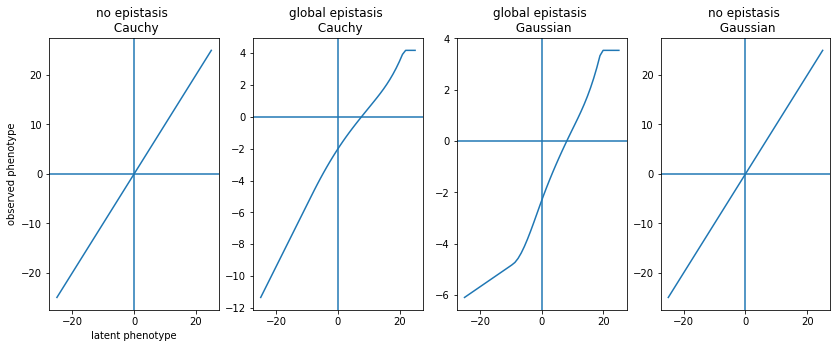

In [12]:
# 1. let's take a look at the epistasis functions
fig, ax = plt.subplots(1, len(fit_df), figsize=[14, 5])
latent = np.linspace(-25, 25)
for idx, model_fit in fit_df.iterrows():
    y = model_fit.model.epistasis_func(latent)
    ax[idx].plot(latent, y)
    ax[idx].axhline(0)
    ax[idx].axvline(0)
    ax[idx].set_title(f"{model_fit.description} \n {model_fit.likelihood}")
ax[0].set_ylabel("observed phenotype")
ax[0].set_xlabel("latent phenotype")
plt.show()

In [13]:
# 2. test on on the octet data - query it
octet_df = final_multi_variant_scores.query("library == 'octet'").reset_index().copy()

In [14]:
# 3. make octet df into binarymap with the same rep as the training?
test_octet_bmap = binarymap.BinaryMap(
    octet_df[["aa_substitutions", "delta_bind"]].dropna(), 
    func_score_col="delta_bind",
    expand=True,
    wtseq=wtseq
)

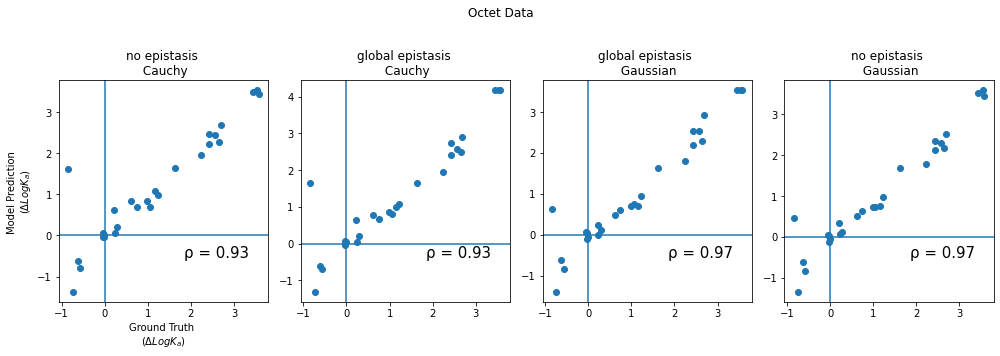

In [15]:
# 4. plot scatter of predictions vs truth
fig, ax = plt.subplots(1, len(fit_df), figsize=[14, 5])

for idx, model_fit in fit_df.iterrows():

    truth = test_octet_bmap.func_scores
    pred = model_fit.model.phenotypes_frombinary(test_octet_bmap.binary_variants, phenotype="observed")
    corr = sp.pearsonr(truth, pred)[0]
    ax[idx].scatter(truth, pred)
    ax[idx].axhline(0)
    ax[idx].axvline(0)
    ax[idx].set_title(f"{model_fit.description} \n {model_fit.likelihood}")
    ax[idx].text(0.6, 0.2, f'ρ = {corr:.2f}',transform=ax[idx].transAxes, size=15)

ax[0].set_ylabel("Model Prediction \n($ \Delta Log K_a$)")
ax[0].set_xlabel("Ground Truth \n($ \Delta Log K_a$)")
fig.suptitle("Octet Data\n")
plt.tight_layout()
fig.savefig("dms-variants-scatter-octet-predictions.png")
plt.show()

In [16]:
# 2. test on on the held out data - query it
held_out_df = final_multi_variant_scores.query("split_set == 'test'").reset_index().copy()

In [17]:
# 3. make held out df into binarymap with the same rep as the training?
test_held_out_bmap = binarymap.BinaryMap(
    held_out_df[["aa_substitutions", "delta_bind"]].dropna(), 
    func_score_col="delta_bind",
    expand=True,
    wtseq=wtseq
)

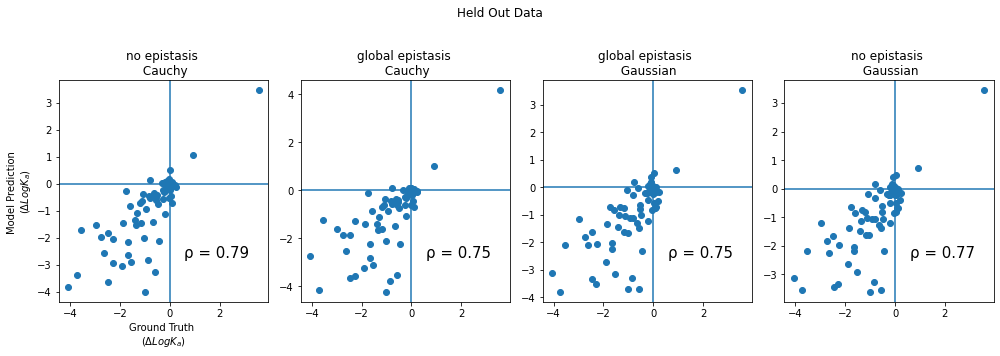

In [18]:
# 4. plot scatter of predictions vs truth
fig, ax = plt.subplots(1, len(fit_df), figsize=[14, 5])

for idx, model_fit in fit_df.iterrows():

    truth = test_held_out_bmap.func_scores
    pred = model_fit.model.phenotypes_frombinary(test_held_out_bmap.binary_variants, phenotype="observed")
    corr = sp.pearsonr(truth, pred)[0]
    
    ax[idx].scatter(truth, pred)
    ax[idx].axhline(0)
    ax[idx].axvline(0)
    ax[idx].set_title(f"{model_fit.description} \n {model_fit.likelihood}")
    ax[idx].text(0.6, 0.2, f'ρ = {corr:.2f}',transform=ax[idx].transAxes, size=15)
    
    
ax[0].set_ylabel("Model Prediction \n($ \Delta Log K_a$)")
ax[0].set_xlabel("Ground Truth \n($ \Delta Log K_a$)")
fig.suptitle("Held Out Data\n")
plt.tight_layout()
fig.savefig("dms-variants-scatter-held-out-predictions.png")
plt.show()